# CSCI 5622: Machine Learning
## Fall 2023
### Instructor: Daniel Acuna, Associate Professor, Department of Computer Science, University of Colorado at Boulder

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Luk Letif"
COLLABORATORS = ""

---

# Homework 5 (75 points)

## Question 1: (25 pts) Implementing Q-Learning in GridWorld

In this question, you will implement a Q-learning agent that navigates a simple grid environment. The environment is a `GridWorld` consisting of a 5x5 grid. The agent's objective is to learn to navigate from a starting position to a goal position as efficiently as possible while avoiding obstacles.

First, you need to understand the provided `GridWorld` class. This class represents the environment in which your Q-learning agent will operate. The grid has empty cells, obstacles, and a goal. Your agent can move up, down, left, or right. If it attempts to move into an obstacle or outside the grid, it stays in its current cell.

**Task**: Familiarize yourself with the `GridWorld` class below and how it works. Pay attention to how the agent's position, obstacles, and the goal are represented and how the rewards are assigned.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.states = [(i, j) for i in range(size) for j in range(size)]
        self.goal = (size - 1, size - 1)  # Goal position
        self.obstacles = [(1, 1), (2, 2), (3, 3)]  # Obstacles
        self.reset()

    def reset(self):
        self.position = (0, 0)  # Start at the top-left corner
        return self.position

    def step(self, action):
        # Actions: 0=Up, 1=Right, 2=Down, 3=Left
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        next_position = tuple(np.add(self.position, moves[action]))

        if next_position in self.obstacles:
            reward = -100  # Penalty for hitting an obstacle
        else:
            # Define rewards
            reward = -1  # Negative reward for each move

        # Check if the new position is valid
        if next_position in self.states and next_position not in self.obstacles:
            self.position = next_position
        
        if self.position == self.goal:
            reward = 100  # Reward for reaching the goal        

        done = self.position == self.goal
        return self.position, reward, done

    def render(self):
        grid = np.zeros((self.size, self.size))
        for obs in self.obstacles:
            grid[obs] = -1  # Represent obstacles
        grid[self.goal] = 2  # Represent the goal
        grid[self.position] = 1  # Represent the agent's position
        print(grid)

In [3]:
env = GridWorld()

In [4]:
# example interaction
env.reset()
print("Initial state")
env.render()
print(f'Action 1, reward: {env.step(1)}')
env.render()
print(f'Action 2, reward: {env.step(2)} (hitting an obstacle)')
env.render()
print(f'Action 1, reward: {env.step(1)} (continue right)')
env.render()

Initial state
[[ 1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  2.]]
Action 1, reward: ((0, 1), -1, False)
[[ 0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  2.]]
Action 2, reward: ((0, 1), -100, False) (hitting an obstacle)
[[ 0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  2.]]
Action 1, reward: ((0, 2), -1, False) (continue right)
[[ 0.  0.  1.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  2.]]


## Q1.1 (25 pts) Implementing the Q-Learning Algorithm

Now, implement the Q-learning algorithm. Your task is to update the Q-table after each action taken by the agent according to the Q-learning update rule.

**Task**: Complete the implementation of the Q-learning algorithm. Initialize the Q-table, choose actions for the agent, and update the Q-table after each action. Use the Q-learning update formula:

$ Q(s, a) \leftarrow Q(s, a) + \alpha [R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)] $

where $ \alpha $ is the learning rate, $ \gamma $ is the discount factor, $ s $ is the current state, $ a $ is the current action, $ s' $ is the new state, and $ R(s, a) $ is the reward received.

Simulate the agent starting from the beginning (with `env.reset()`) and interacting with the environment until done for 10,000 episodes. Use the $\epsilon$-greedy action choice for interacting with the environment:

#### Concept of Epsilon-Greedy Strategy

In Q-learning, an important aspect is the balance between exploration (trying new things) and exploitation (using known information). The ε-greedy strategy is a simple yet effective method to achieve this balance. Here's how it works:

- **Exploration**: With probability ε, the agent chooses an action at random. This allows the agent to explore new actions that might lead to higher rewards but are not currently recognized as such because of insufficient experience.
  
- **Exploitation**: With probability 1-ε, the agent chooses the best known action based on the current Q-table. This utilizes the knowledge the agent has already acquired to make the best decision based on its current information.

#### Implementing Epsilon-Greedy Action Choice

To implement this in your Q-learning agent, you'll need to:

1. **Initialize an Exploration Rate (ε)**: Typically, ε is set to a small value like 0.1, meaning the agent will explore in 10% of its actions and exploit in 90%.

2. **Decide on an Action**:
   - Generate a random number between 0 and 1.
   - If this number is less than ε, select a random action (exploration).
   - If this number is greater than or equal to ε, select the best action according to the Q-table (exploitation).

In [5]:
# Initialize the Q-table
q_table = np.zeros((len(env.states), 4))  # 4 possible actions

num_episodes = 10000

learning_rate = 0.1
discount_factor = 0.95
epsilon = 0.1  # Exploration rate

# Implement the Q-learning algorithm
epidodes_total_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        # YOUR CODE HERE
        # raise NotImplementedError()
        # TODO: scalar variable
        # Convert to integer
        def state_indexing(state, size):
            i, j = state
            return i * size + j
        state_index = state_indexing(state, env.size)

        
        if random.uniform(0, 1) < epsilon:
            # If this number is less than ε, select a random action (exploration).
            action = random.choice(range(4))  
        else:
            # If this number is greater than or equal to ε, select the best action according to the Q-table (exploitation).
            action = np.argmax(q_table[state_index])  

        # agent
        new_state, reward, done = env.step(action)

        # TODO: invalid index 
        new_state_index = state_indexing(new_state, env.size)

        # Update the Q-table 
        old_value = q_table[state_index][action]
        next_max = np.max(q_table[new_state_index]) # max()

        # $ Q(s, a) \leftarrow Q(s, a) + \alpha [R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)] $
        q_table[state_index][action] = old_value + learning_rate * (reward + discount_factor*next_max - old_value)


        state = new_state
        total_reward += reward

    epidodes_total_rewards.append(total_reward)
    

These are the rewards per episode

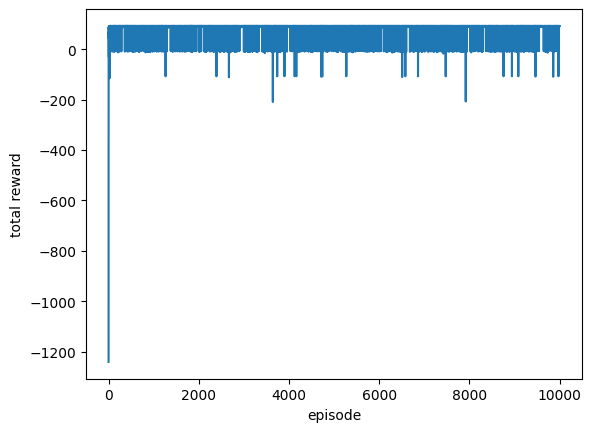

In [6]:
import matplotlib.pyplot as plt
plt.plot(epidodes_total_rewards)
plt.xlabel('episode')
plt.ylabel('total reward');

## Q1.2: (5 pts) Computing and Displaying State Values Based on Q-values

After implementing the Q-learning algorithm, your next task is to compute the value of each state based on the estimated Q-values and display these values in a grid format. This will help visualize the value of each state as learned by the agent during its training.

#### Task Description:

1. **Compute State Values**: The value of a state is typically estimated as the maximum Q-value achievable from that state. For each state in the `GridWorld`, calculate its value based on the Q-table you have obtained from your Q-learning algorithm.

2. **Create a Grid to Display Values**: Once you have the values for each state, create a grid that visually represents these values. This grid will provide a clear representation of how valuable each state is in terms of the potential reward that can be gained from that state.

In [7]:
# def state_indexing(state, size):
#             i, j = state
#             return i * size + j

In [8]:
# Compute the value of each state
# YOUR CODE HERE
# raise NotImplementedError()
size = 4 # odd number
q_table = np.random.rand(size*size, size)

# Convert to integer
def state_indexing(state, size):
    i, j = state
    return i * size + j
            
# Compute State Values: 
state_values = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        # Update the Q-table 
        # old_value = q_table[state_index][action]
        # next_max = np.max(q_table[new_state_index]) # max()
        state_index = state_indexing((i, j), size)
        state_values[i, j] = np.max(q_table[state_index])

# Create a Grid to Display Values: 
print(state_values)

[[0.78927976 0.94218682 0.78777763 0.92154001]
 [0.85768266 0.94610175 0.74104697 0.99456237]
 [0.822318   0.28351124 0.50508424 0.7465371 ]
 [0.79922905 0.59784173 0.92545934 0.78955409]]


### Question 2: Clustering a Synthetic 2D Dataset

In this question, you will work with a synthetic 2D dataset created using scikit-learn. Your task is to model this dataset using clustering techniques. You will explore two different methods: k-means clustering and Gaussian Mixture Models (GMM). The key challenge is to determine the appropriate number of clusters for this dataset using cross-validation techniques.

Before you begin with the clustering tasks, here is the code to generate the synthetic 2D dataset using scikit-learn:

In [9]:
from sklearn.datasets import make_blobs

# Generate synthetic data
# This code generates a dataset (`X`) with 300 samples, distributed among 4 centers with a standard deviation of 0.60 for each cluster. 
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

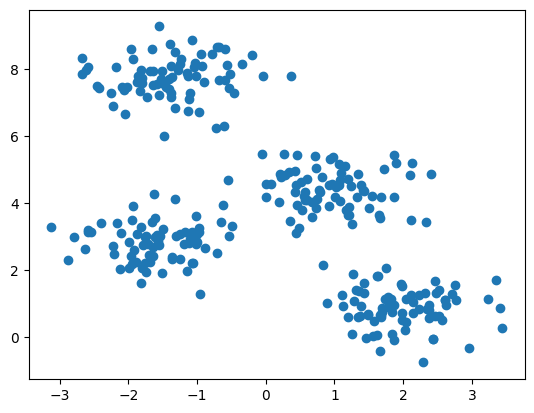

In [10]:
plt.scatter(X[:,0], X[:, 1]);

### Question 2.1: (10 pts) Determining the Number of Clusters with K-Means

#### Task Description:

1. **Implement K-Means Clustering**: Use scikit-learn's K-Means implementation to cluster the synthetic dataset. 

2. **Find the Optimal Number of Clusters**: Determine the appropriate number of clusters using cross-validation techniques like the Elbow Method or the Silhouette Score.

#### Instructions:

- Use the K-Means algorithm from scikit-learn to cluster the dataset.
- Experiment with 2 to 50 clusters.
- Use a cross-validation technique to find the most suitable number of clusters. You will use the within-cluster sum of squares as a metric of loss. You want to minimize that

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import numpy as np

def cross_val_kmeans_wcss(X, n_clusters, cv=5):
    """Calculate average within-cluster sum of squares using cross-validation."""
    wcss_scores = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        # YOUR CODE HERE
        # raise NotImplementedError()
        # Use the K-Means algorithm from scikit-learn to cluster the dataset.
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X_train)

        # TODO: upgrade
        wcss = kmeans.inertia_
        
        wcss_scores.append(wcss)  # Negate to get positive WCSS value

    return np.mean(wcss_scores)

# Determine the optimal number of clusters
range_n_clusters = list(range(2, 51))
wcss_scores = [cross_val_kmeans_wcss(X, n) for n in range_n_clusters]

optimal_n_clusters = range_n_clusters[np.argmin(wcss_scores)]

print(f"The optimal number of clusters is: {optimal_n_clusters}")

The optimal number of clusters is: 50


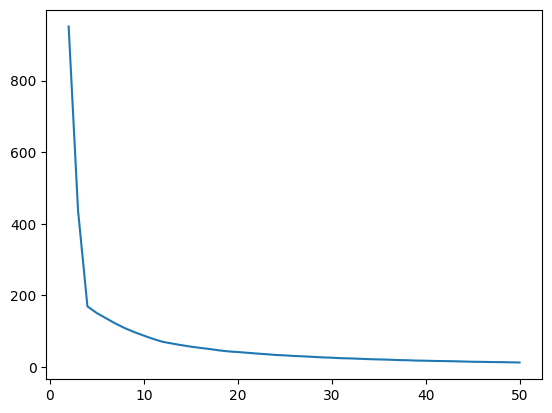

In [12]:
plt.plot(range_n_clusters, wcss_scores)

### Q2.2: (5 pts) What do you think about the optimal number? Does it make sense? Why yes or no?

I think the optimal cluster should be 5-6 (definitely less than 10) according to the 'elbow' method.  I don't see why it has to be 50. that would be over-fitting. 

### Question 2.3: (10 pts) Find the best number of clusters using the silhouette score instead

Use the same code as above, but now use the mean silhouette score as a metric and pick the number of clusters that maximize that metric.

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, KFold


def cross_val_silhouette_score(X, n_clusters, cv=5):
    """Calculate average silhouette score using cross-validation."""
    silhouette_scores = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        # YOUR CODE HERE
        # raise NotImplementedError()
        # Use the K-Means algorithm from scikit-learn to cluster the dataset.
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # error 
        kmeans.fit(X_train)

        # use the mean silhouette score as a metric and pick the number of clusters that maximize that metric
        labels = kmeans.labels_ # 
        score = silhouette_score(X_train, labels)
        
        silhouette_scores.append(score)

    return np.mean(silhouette_scores)

# Determine the optimal number of clusters
range_n_clusters = list(range(2, 51))
silhouette_avg_scores = [cross_val_silhouette_score(X, n) for n in range_n_clusters]

optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]

print(f"The optimal number of clusters is: {optimal_n_clusters}")


The optimal number of clusters is: 4


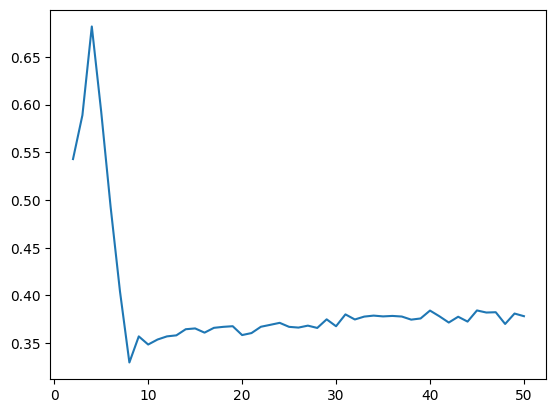

In [14]:
plt.plot(range_n_clusters, silhouette_avg_scores)

### Question 2.4: (20 pts) Gaussian Mixture Model Clustering and Probability Visualization

In this part of the assignment, you will explore clustering using Gaussian Mixture Models (GMM) on the synthetic 2D dataset you've been working with. Your task is to fit a Gaussian Mixture Model with 4 components to the dataset and create visualizations to understand the clustering.

#### Task Description:

1. **Fit a Gaussian Mixture Model**: Use scikit-learn's `GaussianMixture` class to fit a model with 4 components to the dataset.

2. **Create Probability Visualizations**: For each of the 4 clusters, generate a plot showing each point in the dataset, colored based on the probability of that point belonging to the respective cluster. The color should vary from white (low probability) to blue (high probability), giving a visual representation of the likelihood of each point being part of a given cluster.

#### Instructions:

- Initialize and fit a `GaussianMixture` model to the data with 4 components.
- After fitting the model, use the `predict_proba` method to get the probabilities of each point belonging to each of the 4 clusters.
- For each cluster, create a scatter plot of all points in the dataset, coloring each point based on its probability of belonging to that cluster. Use a colormap ranging from white (indicating low probability) to blue (indicating high probability).

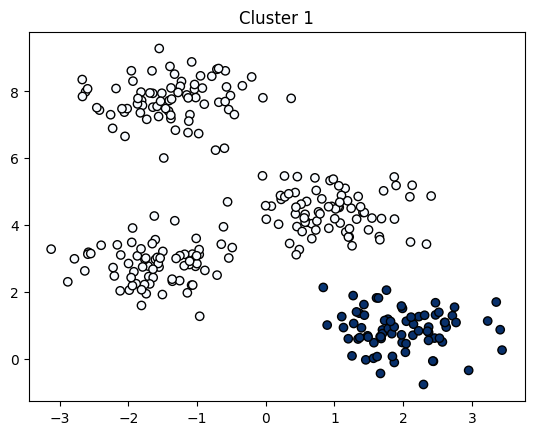

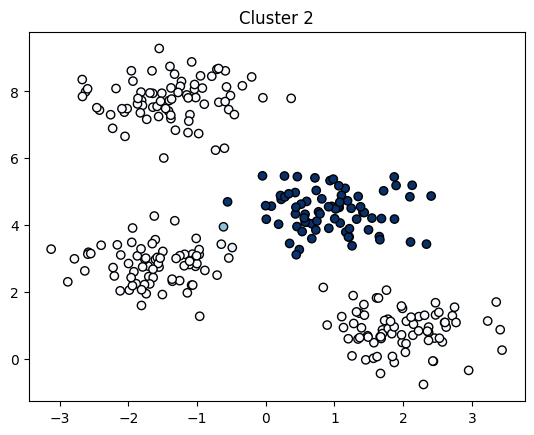

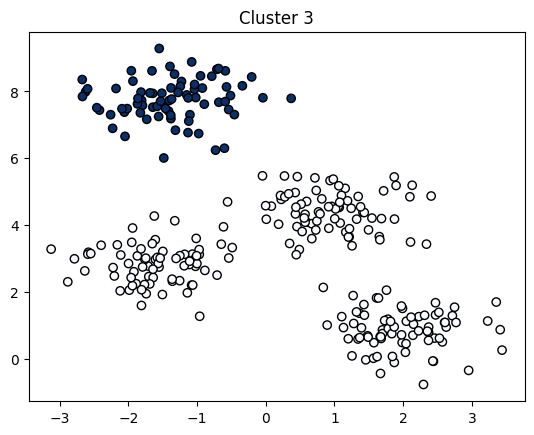

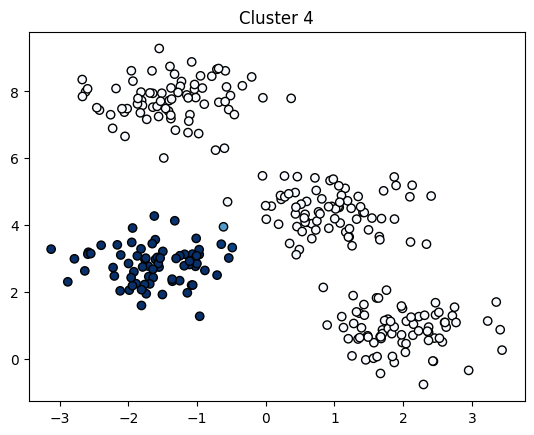

In [15]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# YOUR CODE HERE
# raise NotImplementedError()
# Initialize and fit a GaussianMixture model to the data with 4 components.
gmm = GaussianMixture(n_components=4, random_state=42, n_init=10)
gmm.fit(X)

# After fitting the model, use the predict_proba method to get the probabilities of each point belonging to each of the 4 clusters.
probs = gmm.predict_proba(X)

# For each cluster, create a scatter plot of all points in the dataset, coloring each point based on its probability of belonging to that cluster. Use a colormap ranging from white (indicating low probability) to blue (indicating high probability).
for i in range(4):
    # print(size(X))
    # plt.scatter(X[:,0], X[:, 1]);
    # plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.scatter(X[:, 0], X[:, 1], c=probs[:, i], edgecolors='k', marker='o', cmap='Blues')
    plt.title(f"Cluster {i+1}")
    plt.show() # need to stay 